## Testing of field curvature
### Imaging setup:
- Lens: Olympus MVPLAPO 1x (H45 mesoSPIM rig), zoom settings vary
- Camera: H. Orca Flash 4, exposure 50 ms
- Test sample: Ronchi grating (e.g. 40 lp/mm from Thorlabs) imaged at different focus position (stack).
- immersion: 20 mm of Cargille oil BK7 matching (1.52)
- Illumination: even background using a smartphone screen (all white, 50-70%% intensity)

MTF is accessed across field of view via local contrast metric.

Inspired by Roger Cicala's [blog post](https://www.lensrentals.com/blog/2018/06/developing-a-rapid-mtf-test-for-photo-and-video-lenses/).

This code is exploratory, not meant for streamlined processing.

- Author: Nikita Vladimirov 
- License: GPL-3.

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tif
import glob, os
from pathlib import Path

### Explore TIFF stack of a Ronchi grid at different F-position

In [85]:
datafolder = "D:\\benchtopData\\Lens-testing"
LENS_NAME = "Olympus MVPLAPO-1x"
experiment_key = "6.3x_oil20mm"
datafiles = {
    "1x_oil20mm": datafolder + "\\Olympus-MVPLAPO-1x\\2022-07-14-MVP1x-(H45)-ronchi40-oil20mm\\zoom1.tif",
    "1.25x_oil20mm": datafolder + "\\Olympus-MVPLAPO-1x\\2022-07-14-MVP1x-(H45)-ronchi40-oil20mm\\zoom1.25.tif",
    "2x_oil20mm": datafolder + "\\Olympus-MVPLAPO-1x\\2022-07-14-MVP1x-(H45)-ronchi40-oil20mm\\zoom2.tif",
    "4x_oil20mm": datafolder + "\\Olympus-MVPLAPO-1x\\2022-07-14-MVP1x-(H45)-ronchi40-oil20mm\\zoom4.tif",
    "5x_oil20mm": datafolder + "\\Olympus-MVPLAPO-1x\\2022-07-14-MVP1x-(H45)-ronchi40-oil20mm\\zoom5.tif",
    "6.3x_oil20mm": datafolder + "\\Olympus-MVPLAPO-1x\\2022-07-14-MVP1x-(H45)-ronchi40-oil20mm\\zoom6.3.tif",
}

MAG = float(experiment_key.split('x')[0]) # Effective lens magnification
print(f"Mag={MAG}")
save_figs_folder = ".\\OlympusMVPLAPO-1x-figs\\"

f_step_um = 10 # focus step between planes
CAMERA = "Hamamatsu Orca Flash 4.3"
sensor_dim_mm = (13.312, 13.312) # Orca Flash 4

# The number of ROIs to divide image along each axis
#these give integer number of rois along each axis, with aspect ratio close to the sensor ratio
#N_ROIs_H, N_ROIs_W = 32, 20 # Iris 15
N_ROIs_H, N_ROIs_W = 16, 16 # Orca Flash 4

Mag=6.3


In [86]:
img = tif.imread(datafiles[experiment_key])
im_z, im_h, im_w = img.shape
print(im_z, im_h, im_w)
print(f"Aspect ratio {im_w/im_h}")
assert img.max() < 65535, "Error: image is saturated"

61 2048 2048
Aspect ratio 1.0


In [87]:
roi_h, roi_w = int(im_h/N_ROIs_H), int(im_w/N_ROIs_W)
print(roi_h, roi_w)

128 128


Text(0.5, 1.0, 'ROI in the stack center')

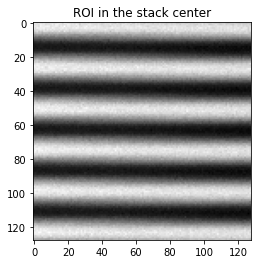

In [88]:
roi = img[im_z//2, roi_h*(N_ROIs_H//2 - 1): roi_h*(N_ROIs_H//2), 
               roi_w*(N_ROIs_W//2 - 1) : roi_w*(N_ROIs_W//2)]
plt.imshow(roi, cmap='gray')
plt.title("ROI in the stack center")

In [89]:
def contrast(roi):
    """Compute the contrast value, (max-min)/(max+min), from the image roi"""
    mini = np.percentile(roi, 1)
    maxi = np.percentile(roi, 99)
    contrast = (maxi - mini) / (maxi + mini)
    return contrast

In [90]:
contrast_table = np.empty((im_z, N_ROIs_H, N_ROIs_W))
for f in range(im_z):
    for j in range(N_ROIs_H):
        for i in range(N_ROIs_W):
            roi = img[f,j*roi_h:(j+1)*roi_h, i*roi_w:(i+1)*roi_w]
            contrast_table[f,j,i] = contrast(roi)

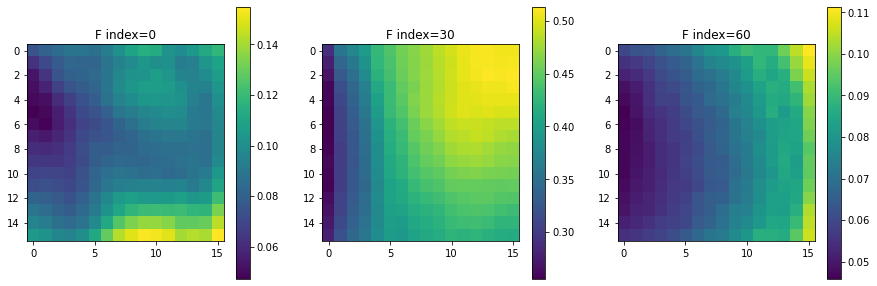

In [91]:
fig = plt.figure(figsize=(15, 5))
for ind, f in enumerate([0, im_z//2, im_z-1]):
    ax = plt.subplot(1, 3, ind+1)
    conmap = ax.imshow(contrast_table[f,:,:])
    ax.set_title("F index=" + str(f))
    plt.colorbar(conmap,ax=ax)

In [92]:
# Save contrast table as TIFF and explore interactively
#tif.imsave(save_figs_folder + experiment_key + "_contrast.tiff", contrast_table)

<ipython-input-93-311aba2da664>:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


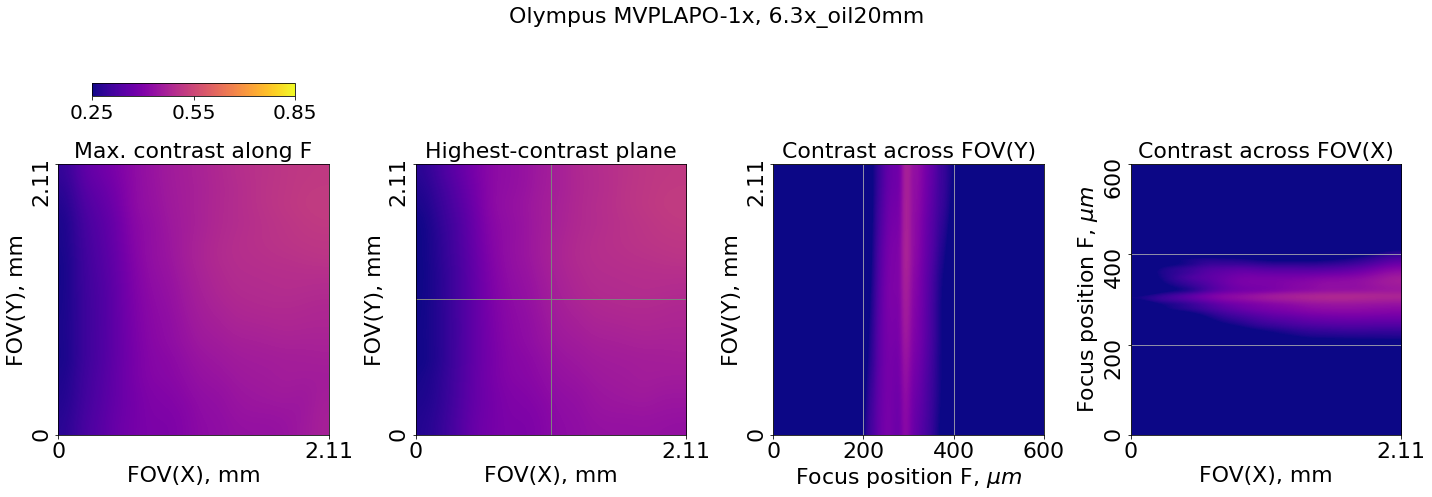

In [93]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
CMIN, CMAX = 0.25, 0.85
USE_COLORBAR = True
FONTSIZE_LABELS = FONTSIZE_TITLES = 22
cmap = 'plasma'
# slice the contrast map along XZ and YZ axis, therough the center
contrast_yz = np.squeeze(contrast_table[:,:,N_ROIs_W//2])
contrast_xz = np.squeeze(contrast_table[:,N_ROIs_H//2,:])
z_contrast_max = np.argmax(contrast_table[:,N_ROIs_H//2,N_ROIs_W//2])
#cmin, cmax = contrast_table.min(), contrast_table.max()
cmin, cmax = CMIN, CMAX
y_range = np.linspace(0, sensor_dim_mm[0], N_ROIs_H) / MAG
x_range = np.linspace(0, sensor_dim_mm[1], N_ROIs_W) / MAG
f_range = np.linspace(0, f_step_um*(im_z-1), im_z)

fig = plt.figure(figsize=(20, 8))
fig.suptitle(f'{LENS_NAME}, {experiment_key}', fontsize=FONTSIZE_TITLES)
# =======================================================================
ax0 = plt.subplot(1, 4, 1)
conmap0 = ax0.imshow(contrast_table.max(axis=0), vmin=cmin, vmax=cmax,
                     extent=[0, x_range[-1], 0, y_range[-1]], 
                     aspect='equal', cmap=cmap, interpolation='bicubic')
ax0.tick_params(axis='both', which='major', labelsize=FONTSIZE_LABELS)
ax0.set_xticks(np.round((0, x_range[-1]),2))
ax0.set_yticks(np.round((0, y_range[-1]),2))
ax0.set_yticklabels(['0', str(np.round(y_range[-1],2))])
ax0.set_xticklabels(['0', str(np.round(x_range[-1],2))])
ax0.tick_params(axis='y', rotation=90)
ax0.set_title("Max. contrast along F", fontsize=FONTSIZE_TITLES)
ax0.set_xlabel("FOV(X), mm", fontsize=FONTSIZE_LABELS)
ax0.set_ylabel("FOV(Y), mm", fontsize=FONTSIZE_LABELS)
# =======================================================================
ax1 = plt.subplot(1, 4, 2)
ax1.imshow(contrast_table[z_contrast_max,:,:], vmin=cmin, vmax=cmax,
                     extent=[0, x_range[-1], 0, y_range[-1]], 
                     aspect='equal', cmap=cmap, interpolation='bicubic')
ax1.tick_params(axis='both', which='major', labelsize=FONTSIZE_LABELS)
ax1.set_title(f"Highest-contrast plane", fontsize=FONTSIZE_TITLES)
ax1.set_xticks(np.round((0, x_range[-1]),2))
ax1.set_yticks(np.round((0, y_range[-1]),2))
ax1.set_yticklabels(['0', str(np.round(y_range[-1],2))])
ax1.set_xticklabels(['0', str(np.round(x_range[-1],2))])
ax1.tick_params(axis='y', rotation=90)
ax1.set_xlabel("FOV(X), mm", fontsize=FONTSIZE_LABELS)
ax1.set_ylabel("FOV(Y), mm", fontsize=FONTSIZE_LABELS)
ax1.axhline(y_range[-1]/2, c="gray", linewidth=1)
ax1.axvline(x_range[-1]/2, c="gray", linewidth=1)
# =======================================================================
ax2 = plt.subplot(1, 4, 3)
aspect = f_step_um*(im_z-1) / x_range[-1]
conmap3 = ax2.imshow(contrast_yz.T, vmin=cmin, vmax=cmax,
                     extent=[0, f_step_um*(im_z-1), 0, y_range[-1]], 
                     aspect=aspect, 
                     cmap=cmap, interpolation='bicubic')
ax2.tick_params(axis='both', which='major', labelsize=FONTSIZE_LABELS)
ax2.tick_params(axis='y', rotation=90)
ax2.set_yticks(np.round((0, y_range[-1]),2))
ax2.set_yticklabels(['0', str(np.round(y_range[-1],2))])
ax2.set_title("Contrast across FOV(Y)", fontsize=FONTSIZE_TITLES)
ax2.set_xlabel("Focus position F, $\mu m$", fontsize=FONTSIZE_LABELS)
ax2.set_ylabel("FOV(Y), mm", fontsize=FONTSIZE_LABELS)
ax2.grid(True)
# =======================================================================
ax3 = plt.subplot(1, 4, 4)
conmap1 = ax3.imshow(contrast_xz, vmin=cmin, vmax=cmax, 
                     extent=[0, x_range[-1], 0, f_step_um*(im_z-1)], 
                     aspect=1/aspect, cmap=cmap, interpolation='bicubic')
ax3.set_xticks(np.round((0, x_range[-1]),2))
ax3.tick_params(axis='both', which='major', labelsize=FONTSIZE_LABELS)
ax3.set_yticks([0, 200, 400, 600])
ax3.tick_params(axis='y', rotation=90)
ax3.set_title("Contrast across FOV(X)", fontsize=FONTSIZE_TITLES)
ax3.set_ylabel("Focus position F, $\mu m$", fontsize=FONTSIZE_LABELS)
ax3.set_xlabel("FOV(X), mm", fontsize=FONTSIZE_LABELS)
ax3.set_xticklabels(['0', str(np.round(x_range[-1],2))])
ax3.grid(True)

if USE_COLORBAR:
    axins = inset_axes(ax0,
                       width="75%",  # width = 5% of parent_bbox width
                       height="5%",  # height : 50%
                       loc='upper center',
                       bbox_to_anchor=(0, 0.3, 1, 1),
                       bbox_transform=ax0.transAxes,
                       borderpad=0,
                       )
    cbar = plt.colorbar(conmap0, cax=axins, ticks=(0.25, 0.55, 0.85), orientation='horizontal')
    cbar.ax.tick_params(labelsize=FONTSIZE_LABELS-2)
fig.tight_layout()

In [94]:
#fig.savefig(save_figs_folder + experiment_key + f"_contrast_map({cmap})_min-max({cmin},{cmax}).png")

In [95]:
save_figs_folder + experiment_key + f"_contrast_map({cmap})_min-max({cmin},{cmax}).png"

'.\\OlympusMVPLAPO-1x-figs\\6.3x_oil20mm_contrast_map(plasma)_min-max(0.25,0.85).png'

In [96]:
print(f'Average contrast in the highest-contrast plane: {contrast_table[z_contrast_max,:,:].mean():.2f}')
print(f'Min contrast in the highest-contrast plane: {contrast_table[z_contrast_max,:,:].min():.2f}')
print(f'Max contrast in the highest-contrast plane: {contrast_table[z_contrast_max,:,:].max():.2f}')

Average contrast in the highest-contrast plane: 0.42
Min contrast in the highest-contrast plane: 0.25
Max contrast in the highest-contrast plane: 0.53


Sag across FOV_X: 12 um
Sag across FOV_Y: 13 um
DOF (um), by gaussian fitting fwhm: 149


Text(0.1, 0.3, 'Sag across FOV_Y: 13 um')

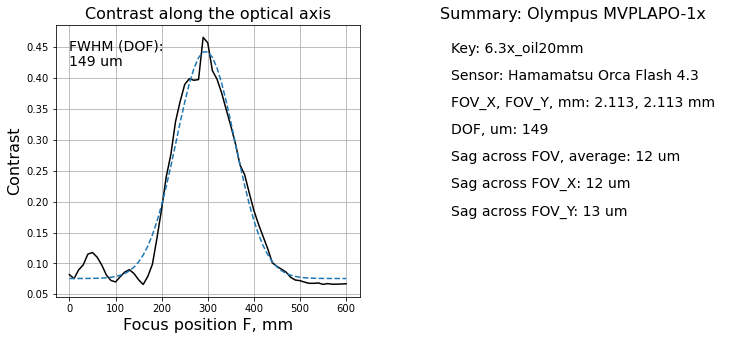

In [97]:
import lib.optimization as opt # custom-made optimization library

# gaussian fit of contrast profile along the optical axis
fit_center, fit_sigma, fit_amp, fit_offset = opt.fit_gaussian_1d(contrast_table[:,N_ROIs_H//2,N_ROIs_W//2], f_range)

# Find curvature sag across FOV_X:
fit_center_left,  _, _, _ = opt.fit_gaussian_1d(contrast_table[:,N_ROIs_H//2,0], f_range)
fit_center_right,  _, _, _ = opt.fit_gaussian_1d(contrast_table[:,N_ROIs_H//2,-1], f_range)

# Find curvature sag across FOV_Y:
fit_center_down, _, _, _ = opt.fit_gaussian_1d(contrast_table[:,0,N_ROIs_W//2], f_range)
fit_center_up, _, _, _ = opt.fit_gaussian_1d(contrast_table[:,0,N_ROIs_W//2], f_range)

sag_x = abs(round(fit_center - 0.5*(fit_center_left + fit_center_right)))
sag_y = abs(round(fit_center - 0.5*(fit_center_up + fit_center_down)))
dof = round(opt.sigma2fwhm(fit_sigma))
print(f"Sag across FOV_X: {sag_x} um")
print(f"Sag across FOV_Y: {sag_y} um")
print(f"DOF (um), by gaussian fitting fwhm: {dof}")



fig = plt.figure(figsize=(12, 5))

ax1 = plt.subplot(1, 2, 1)
ax1.plot(f_range, contrast_table[:,N_ROIs_H//2,N_ROIs_W//2], '-k')
ax1.plot(f_range, opt.gaussian_1d(f_range, fit_center, fit_sigma, fit_amp, fit_offset),'--')
ax1.text(0,0.9*contrast_table[:,N_ROIs_H//2,N_ROIs_W//2].max(),f"FWHM (DOF): \n{dof} um", fontsize=14)
ax1.set_title("Contrast along the optical axis", fontsize=16)
ax1.set_xlabel("Focus position F, mm", fontsize=16)
ax1.set_ylabel("Contrast", fontsize=16)
ax1.grid(True)

ax2 = plt.subplot(1, 2, 2)
ax2.axis('off')
ax2.set_title(f"Summary: {LENS_NAME}", fontsize=16)
ax2.text(0.1, 0.9, f"Key: {experiment_key}", fontsize=14) 
ax2.text(0.1, 0.8, f"Sensor: {CAMERA}", fontsize=14)
ax2.text(0.1, 0.7, f"FOV_X, FOV_Y, mm: {x_range[-1]:.3f}, {y_range[-1]:.3f} mm", fontsize=14)
ax2.text(0.1, 0.6, f"DOF, um: {dof}", fontsize=14)
ax2.text(0.1, 0.5, f"Sag across FOV, average: {round(0.5*(sag_x + sag_y))} um", fontsize=14)
ax2.text(0.1, 0.4, f"Sag across FOV_X: {sag_x} um", fontsize=14)
ax2.text(0.1, 0.3, f"Sag across FOV_Y: {sag_y} um", fontsize=14)

In [98]:
#fig.savefig(save_figs_folder + experiment_key + "_contrast_plot.png")

In [99]:
# DOF calculation for the lens
# Based on [MicroscopyU](https://www.microscopyu.com/microscopy-basics/depth-of-field-and-depth-of-focus) formula.
# All units micron. Air objective.
n_det = 1 
cam_px_size = 6.5
lamb_em = 0.550
NA = 0.08

DOF = n_det*lamb_em/NA**2 + n_det*cam_px_size/(MAG*NA)
print(f"Estimated DOF={int(DOF)} um, in air")

Estimated DOF=98 um, in air
